# import

In [52]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [53]:
import os
os.environ["MKL_NUM_THREADS"] = "2"
os.environ["NUMEXPR_NU M_THREADS"] = "2"
os.environ["OMP_NUM_THREADS"] = "2"
import time
import pprint

import numpy
import torch
import torch.nn as nn
import torch.utils.data as data
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.cuda.amp import autocast
from torch.optim.lr_scheduler import LambdaLR
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import DataLoader
from advertorch.attacks import GradientSignAttack

In [54]:
from SSL.util.loaders import load_dataset, load_optimizer, load_callbacks, load_preprocesser
from SSL.util.model_loader import load_model
from SSL.util.checkpoint import CheckPoint, mSummaryWriter
from SSL.util.utils import reset_seed, get_datetime, track_maximum, dotdict
from SSL.ramps import Warmup, sigmoid_rampup
from SSL.losses import JensenShanon

from metric_utils.metrics import CategoricalAccuracy, FScore, ContinueAverage

# Arguments

In [55]:
import argparse
parser = argparse.ArgumentParser()
parser.add_argument("--from_config", default="", type=str)
parser.add_argument("-d", "--dataset_root", default="../../datasets", type=str)
parser.add_argument("-D", "--dataset", default="esc10", type=str, help="available [ubs8k | cifar10]")

group_t = parser.add_argument_group("Commun parameters")
group_t.add_argument("-m", "--model", default="wideresnet28_2", type=str)
group_t.add_argument("--supervised_ratio", default=0.1, type=float)
group_t.add_argument("--batch_size", default=64, type=int)
group_t.add_argument("--nb_epoch", default=200, type=int)
group_t.add_argument("--learning_rate", default=0.003, type=float)
group_t.add_argument("--resume", action="store_true", default=False)
group_t.add_argument("--seed", default=1234, type=int)

group_m = parser.add_argument_group("Model parameters")
group_m.add_argument("--num_classes", default=10, type=int)

group_u = parser.add_argument_group("Datasets parameters")
group_u.add_argument("-t", "--train_folds", nargs="+", default=[1, 2, 3, 4], type=int)
group_u.add_argument("-v", "--val_folds", nargs="+", default=[5], type=int)

group_s = parser.add_argument_group("Student teacher parameters")
group_s.add_argument("--ema_alpha", default=0.999, type=float)
group_s.add_argument("--warmup_length", default=50, type=int)
group_s.add_argument("--lambda_cost_max", default=1, type=float)
group_s.add_argument("--teacher_noise", default=2, type=float)
group_s.add_argument("--epsilon", default=0.02, type=float)


group_l = parser.add_argument_group("Logs")
group_l.add_argument("--checkpoint_root", default="../../model_save/", type=str)
group_l.add_argument("--tensorboard_root", default="../../tensorboard/", type=str)
group_l.add_argument("--checkpoint_path", default="mean-teacher", type=str)
group_l.add_argument("--tensorboard_path", default="mean-teacher", type=str)
group_l.add_argument("--tensorboard_sufix", default="", type=str)

args=parser.parse_args("")

tensorboard_path = os.path.join(args.tensorboard_root, args.dataset, args.tensorboard_path)
checkpoint_path = os.path.join(args.checkpoint_root, args.dataset, args.checkpoint_path)

In [56]:
pprint.pprint(vars(args))

{'batch_size': 64,
 'checkpoint_path': 'mean-teacher',
 'checkpoint_root': '../../model_save/',
 'dataset': 'esc10',
 'dataset_root': '../../datasets',
 'ema_alpha': 0.999,
 'epsilon': 0.02,
 'from_config': '',
 'lambda_cost_max': 1,
 'learning_rate': 0.003,
 'model': 'wideresnet28_2',
 'nb_epoch': 200,
 'num_classes': 10,
 'resume': False,
 'seed': 1234,
 'supervised_ratio': 0.1,
 'teacher_noise': 2,
 'tensorboard_path': 'mean-teacher',
 'tensorboard_root': '../../tensorboard/',
 'tensorboard_sufix': '',
 'train_folds': [1, 2, 3, 4],
 'val_folds': [5],
 'warmup_length': 50}


# initialisation

In [57]:
reset_seed(args.seed)

# Prepare the dataset

In [58]:
train_transform, val_transform = load_preprocesser(args.dataset, "mean-teacher")
train_transform

Sequential(
  (0): MelSpectrogram(
    (spectrogram): Spectrogram()
    (mel_scale): MelScale()
  )
  (1): AmplitudeToDB()
)

In [59]:
manager, train_loader, val_loader = load_dataset(
    args.dataset,
    "mean-teacher",
    
    dataset_root = args.dataset_root,
    supervised_ratio = args.supervised_ratio,
    batch_size = args.batch_size,
    train_folds = args.train_folds,
    val_folds = args.val_folds,

    train_transform=train_transform,
    val_transform=val_transform,
    
    num_workers=0,
    pin_memory=True,

    verbose = 2
)

Dataset already downloaded and verified.
Dataset already downloaded and verified.
s_batch_size:  6
u_batch_size:  58


In [60]:
input_shape = tuple(train_loader._iterables[0].dataset[0][0].shape)
input_shape

(64, 431)

# Prep model

In [61]:
torch.cuda.empty_cache()

model_func = load_model(args.dataset, args.model)

student = model_func(input_shape=input_shape, num_classes = args.num_classes)
teacher = model_func(input_shape=input_shape, num_classes = args.num_classes)

student = student.cuda()
teacher = teacher.cuda()

# We do not need gradient for the teacher model
for p in teacher.parameters():
    p.detach()

In [62]:
from torchsummary import summary

s = summary(student, input_shape)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 32, 64, 431]             864
       BatchNorm2d-2          [-1, 32, 64, 431]              64
              ReLU-3          [-1, 32, 64, 431]               0
         MaxPool2d-4          [-1, 32, 32, 216]               0
            Conv2d-5          [-1, 32, 32, 216]           9,216
       BatchNorm2d-6          [-1, 32, 32, 216]              64
              ReLU-7          [-1, 32, 32, 216]               0
            Conv2d-8          [-1, 32, 32, 216]           9,216
       BatchNorm2d-9          [-1, 32, 32, 216]              64
             ReLU-10          [-1, 32, 32, 216]               0
       BasicBlock-11          [-1, 32, 32, 216]               0
           Conv2d-12          [-1, 32, 32, 216]           9,216
      BatchNorm2d-13          [-1, 32, 32, 216]              64
             ReLU-14          [-1, 32, 

# training parameters

In [63]:
# tensorboard
title_element = (args.model, args.supervised_ratio, get_datetime(), model_func.__name__)
tensorboard_title = "%s/%sS/%s_%s_JS" % title_element

title_element = (args.model, args.supervised_ratio, get_datetime(), model_func.__name__)
checkpoint_title = "%s/%sS/%s_%s_JS" % title_element

tensorboard = mSummaryWriter(log_dir="%s/%s" % (tensorboard_path, tensorboard_title), comment=model_func.__name__)
print(os.path.join(tensorboard_path, tensorboard_title))

../../tensorboard/esc10/mean-teacher/wideresnet28_2/0.1S/2020-11-03_16:15:14_wideresnet28_2_JS


## Adversarial generator

In [64]:
# adversarial generation
adv_generator = GradientSignAttack(
    student, loss_fn=nn.CrossEntropyLoss(reduction="sum"),
    eps=args.epsilon, clip_min=-numpy.inf, clip_max=numpy.inf, targeted=False
)

## optimizer & callbacks

In [65]:
optimizer = load_optimizer(args.dataset, "mean-teacher", student=student, teacher=teacher)
callbacks = load_callbacks(args.dataset, "mean-teacher", optimizer=optimizer, nb_epoch=args.nb_epoch)

In [66]:
# losses
loss_ce = nn.CrossEntropyLoss(reduction="mean") # Supervised loss
consistency_cost = nn.MSELoss(reduction="mean") # Unsupervised loss
# consistency_cost = JensenShanon

lambda_cost = Warmup(args.lambda_cost_max, args.warmup_length, sigmoid_rampup)
callbacks += [lambda_cost]

# Checkpoint
checkpoint = CheckPoint(student, optimizer, mode="max", name="%s/%s.torch" % (checkpoint_path, checkpoint_title))

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

## Metrics definition

In [67]:
def metrics_calculator():
    def c(logits, y):
        with torch.no_grad():
            y_one_hot = F.one_hot(y, num_classes=args.num_classes)
            
            pred = torch.softmax(logits, dim=1)
            arg = torch.argmax(logits, dim=1)
            
            acc = c.fn.acc(arg, y).mean
            f1 = c.fn.f1(pred, y_one_hot).mean
            
            return acc, f1,
            
    c.fn = dotdict(
        acc = CategoricalAccuracy(),
        f1 = FScore(),
    )
    
    return c

In [68]:
calc_student_s_metrics = metrics_calculator()
calc_student_u_metrics = metrics_calculator()
calc_teacher_s_metrics = metrics_calculator()
calc_teacher_u_metrics = metrics_calculator()

avg_Sce = ContinueAverage()
avg_Tce = ContinueAverage()
avg_ccost = ContinueAverage()

softmax_fn = nn.Softmax(dim=1)

def reset_metrics():
    for d in [calc_student_s_metrics.fn, calc_student_u_metrics.fn, calc_teacher_s_metrics.fn, calc_teacher_u_metrics.fn]:
        for fn in d.values():
            fn.reset()

maximum_tracker = track_maximum()

## Can resume previous training

## training function

In [69]:
UNDERLINE_SEQ = "\033[1;4m"
RESET_SEQ = "\033[0m"

header_form = "{:<8.8} {:<6.6} - {:<6.6} - {:<10.8} {:<8.6} {:<8.6} {:<8.6} {:<8.6} {:<8.6} {:<8.6} | {:<10.8} {:<8.6} {:<8.6} {:<8.6} {:<8.6} {:<8.6} - {:<8.6}"
value_form  = "{:<8.8} {:<6d} - {:<6d} - {:<10.8} {:<8.4f} {:<8.4f} {:<8.4f} {:<8.4f} {:<8.4f} {:<8.4f} | {:<10.8} {:<8.4f} {:<8.4f} {:<8.4f} {:<8.4f} {:<8.4f} - {:<8.4f}"
header = header_form.format(".               ", "Epoch",  "%", "Student:", "ce", "ccost", "acc_s", "f1_s", "acc_u", "f1_u", "Teacher:", "ce", "acc_s", "f1_s", "acc_u", "f1_u" , "Time")

train_form = value_form
val_form = UNDERLINE_SEQ + value_form + RESET_SEQ

print(header)

.        Epoch  - %      - Student:   ce       ccost    acc_s    f1_s     acc_u    f1_u     | Teacher:   ce       acc_s    f1_s     acc_u    f1_u     - Time    


In [70]:
def update_teacher_model(student_model, teacher_model, alpha, epoch):
    
    # Use the true average until the exponential average is more correct
    alpha = min(1 - 1 / (epoch + 1), alpha)
    
    for param, ema_param in zip(student_model.parameters(), teacher_model.parameters()):
        ema_param.data.mul_(alpha).add_(param.data,  alpha = 1-alpha)

class Noisify(nn.Module):
    def __init__(self, noise_level: int = 15):
        super().__init__()

        self.noise_level = noise_level

    def forward(self, x):
        return x + (torch.rand(x.shape).cuda() * self.noise_level)

noise_fn = lambda x: x
if args.teacher_noise != 0:
    noise_fn = Noisify(noise_level=args.teacher_noise)
    noise_fn = noise_fn.cuda()

In [71]:
def train(epoch):
    start_time = time.time()
    print("")
    
    nb_batch = len(train_loader)

    reset_metrics()
    student.train()

    for i, (S, U) in enumerate(train_loader):        
        x_s, y_s = S
        x_u, y_u = U
        
        x_s, x_u = x_s.cuda(), x_u.cuda()
        y_s, y_u = y_s.cuda(), y_u.cuda()
        
        # Student predictions
        with autocast():
            student_s_logits = student(x_s)        
            student_u_logits = student(x_u)

        # ---- adversarial examples ----
        # for U using student model and pseudo label
        student.eval()
        pseudo_pred_u = torch.argmax(student_u_logits, dim=1)
        adv_u = adv_generator.perturb(x_u, pseudo_pred_u)
        student.train()

        # Teacher prediction on adv U
        with autocast():
            teacher_adv_u_logits = teacher(adv_u)
        
        # ---- losses ----
        with autocast():
            loss = loss_ce(student_s_logits, y_s)
            ccost = consistency_cost(softmax_fn(student_u_logits), softmax_fn(teacher_adv_u_logits))
            total_loss = loss + lambda_cost() * ccost
        
        # step
        for p in student.parameters(): p.grad = None
        total_loss.backward()
        optimizer.step()

        with torch.set_grad_enabled(False):
            # Teacher prediction (for metrics purpose)
            with autocast():
                teacher_s_logits = teacher(x_s)
                teacher_u_logits = teacher(x_u)
                _teacher_loss = loss_ce(teacher_s_logits, y_s)
            
            # Update teacher
            update_teacher_model(student, teacher, args.ema_alpha, epoch*nb_batch + i)
            
            # Compute the metrics for the student
            student_s_metrics = calc_student_s_metrics(student_s_logits, y_s)
            student_u_metrics = calc_student_u_metrics(student_u_logits, y_u)
            student_s_acc, student_s_f1, student_u_acc, student_u_f1 = *student_s_metrics, *student_u_metrics
            
            # Compute the metrics for the teacher
            teacher_s_metrics = calc_teacher_s_metrics(teacher_s_logits, y_s)
            teacher_u_metrics = calc_teacher_u_metrics(teacher_u_logits, y_u)
            teacher_s_acc, teacher_s_f1, teacher_u_acc, teacher_u_f1 = *teacher_s_metrics, *teacher_u_metrics
            
            # Running average of the two losses
            student_running_loss = avg_Sce(loss.item()).mean
            teacher_running_loss = avg_Tce(_teacher_loss.item()).mean
            running_ccost = avg_ccost(ccost.item()).mean

            # logs
            print(train_form.format(
                "Training: ", epoch + 1, int(100 * (i + 1) / nb_batch),
                "", student_running_loss, running_ccost, *student_s_metrics, *student_u_metrics,
                "", teacher_running_loss, *teacher_s_metrics, *teacher_u_metrics,
                time.time() - start_time
            ), end="\r")

    tensorboard.add_scalar("train/student_acc_s", student_s_acc, epoch)
    tensorboard.add_scalar("train/student_acc_u", student_u_acc, epoch)
    tensorboard.add_scalar("train/student_f1_s", student_s_f1, epoch)
    tensorboard.add_scalar("train/student_f1_u", student_u_f1, epoch)
    
    tensorboard.add_scalar("train/teacher_acc_s", teacher_s_acc, epoch)
    tensorboard.add_scalar("train/teacher_acc_u", teacher_u_acc, epoch)
    tensorboard.add_scalar("train/teacher_f1_s", teacher_s_f1, epoch)
    tensorboard.add_scalar("train/teacher_f1_u", teacher_u_f1, epoch)
    
    tensorboard.add_scalar("train/student_loss", student_running_loss, epoch)
    tensorboard.add_scalar("train/teacher_loss", teacher_running_loss, epoch)
    tensorboard.add_scalar("train/consistency_cost", running_ccost, epoch)

In [72]:
def val(epoch):
    start_time = time.time()
    print("")
    reset_metrics()
    student.eval()
    
    with torch.set_grad_enabled(False):
        for i, (X, y) in enumerate(val_loader):
            X = X.cuda()
            y = y.cuda()

            # Predictions
            with autocast():
                student_logits = student(X)        
                teacher_logits = teacher(X)

                # Calculate supervised loss (only student on S)
                loss = loss_ce(student_logits, y)
                _teacher_loss = loss_ce(teacher_logits, y) # for metrics only
                ccost = consistency_cost(softmax_fn(student_logits), softmax_fn(teacher_logits))
            
            # Compute the metrics
            y_one_hot = F.one_hot(y, num_classes=args.num_classes)
            
            # ---- student ----
            student_metrics = calc_student_s_metrics(student_logits, y)
            student_acc, student_f1 = student_metrics
            
            # ---- teacher ----
            teacher_metrics = calc_teacher_s_metrics(teacher_logits, y)
            teacher_acc, teacher_f1 = teacher_metrics

            # Running average of the two losses
            student_running_loss = avg_Sce(loss.item()).mean
            teacher_running_loss = avg_Tce(_teacher_loss.item()).mean
            running_ccost = avg_ccost(ccost.item()).mean

            # logs
            print(val_form.format(
                "Validation: ", epoch + 1, int(100 * (i + 1) / len(val_loader)),
                "", student_running_loss, running_ccost, *student_metrics, 0.0, 0.0,
                "", teacher_running_loss, *teacher_metrics, 0.0, 0.0,
                time.time() - start_time
            ), end="\r")

    tensorboard.add_scalar("val/student_acc", student_acc, epoch)
    tensorboard.add_scalar("val/student_f1", student_f1, epoch)
    tensorboard.add_scalar("val/teacher_acc", teacher_acc, epoch)
    tensorboard.add_scalar("val/teacher_f1", teacher_f1, epoch)
    tensorboard.add_scalar("val/student_loss", student_running_loss, epoch)
    tensorboard.add_scalar("val/teacher_loss", teacher_running_loss, epoch)
    tensorboard.add_scalar("val/consistency_cost", running_ccost, epoch)
    
    tensorboard.add_scalar("hyperparameters/learning_rate", get_lr(optimizer), epoch)
    tensorboard.add_scalar("hyperparameters/lambda_cost_max", lambda_cost(), epoch)
    
    tensorboard.add_scalar("max/student_acc", maximum_tracker("student_acc", student_acc), epoch )
    tensorboard.add_scalar("max/teacher_acc", maximum_tracker("teacher_acc", teacher_acc), epoch )
    tensorboard.add_scalar("max/student_f1", maximum_tracker("student_f1", student_f1), epoch )
    tensorboard.add_scalar("max/teacher_f1", maximum_tracker("teacher_f1", teacher_f1), epoch )

    checkpoint.step(teacher_acc)
    for c in callbacks:
        c.step()


# Training

In [73]:
print(header)

if args.resume:
    checkpoint.load_last()

start_epoch = checkpoint.epoch_counter
end_epoch = args.nb_epoch

for e in range(start_epoch, args.nb_epoch):
    train(e)
    val(e)
    
    tensorboard.flush()

  0.6464   |            0.7438   1.0000   1.0000   0.6276   0.6194   - 2.0415  
Validati 140    - 100    -            6.9365   0.0137   0.5703   0.5863   0.0000   0.0000   |            0.7451   0.5781   0.5756   0.0000   0.0000   - 0.0847  
Training 141    - 100    -            6.9014   0.0137   1.0000   1.0000   0.6414   0.6350   |            0.7418   1.0000   1.0000   0.6103   0.6119   - 2.0433  
Validati 141    - 100    -            6.8901   0.0137   0.6719   0.6761   0.0000   0.0000   |            0.7422   0.7266   0.7289   0.0000   0.0000   - 0.0806  
Training 142    - 100    -            6.8555   0.0137   1.0000   1.0000   0.6379   0.6425   |            0.7388   1.0000   1.0000   0.6310   0.6229   - 2.0363  
Validati 142    - 100    -            6.8450   0.0137   0.5391   0.5603   0.0000   0.0000   |            0.7406   0.4844   0.5016   0.0000   0.0000   - 0.0803  
Training 143    - 100    -            6.8108   0.0137   1.0000   1.0000   0.6517   0.6512   |            0.7373   1

## Save the hyper parameters and the metrics

In [74]:
hparams = {}
for key, value in args.__dict__.items():
    hparams[key] = str(value)
    
final_metrics = {
    "max_student_acc": maximum_tracker.max["student_acc"],
    "max_teacher_acc": maximum_tracker.max["teacher_acc"],
    "max_student_f1": maximum_tracker.max["student_f1"],
    "max_teacher_f1": maximum_tracker.max["teacher_f1"],
}

tensorboard.add_hparams(hparams, final_metrics)
tensorboard.flush()
tensorboard.close()

## display

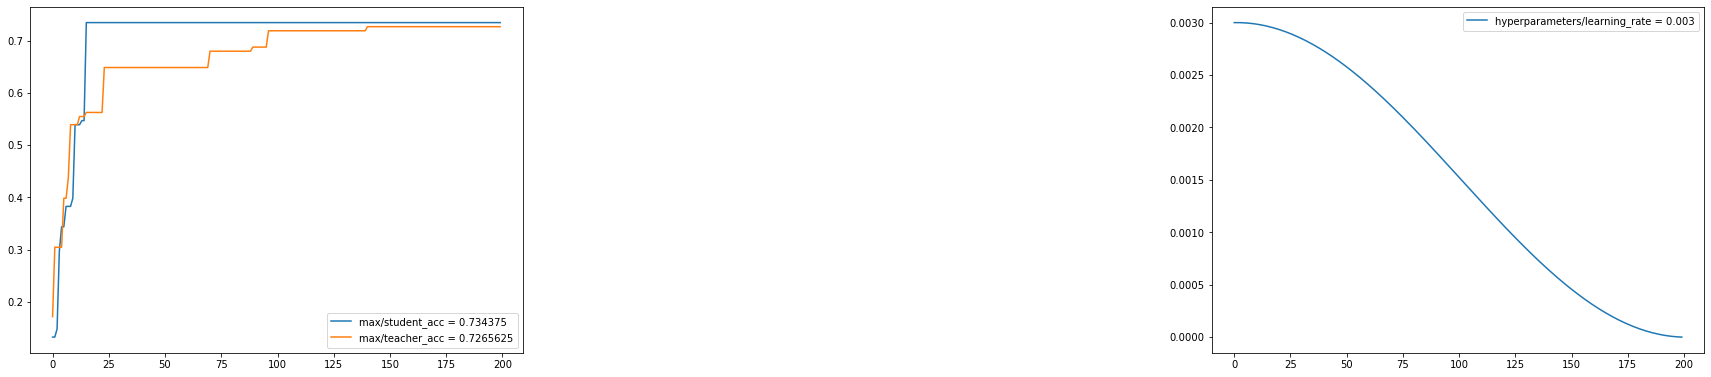

In [75]:
import matplotlib.pyplot as plt
import numpy as np

x = list(range(checkpoint.epoch_counter))
sm = lambda y, w: np.convolve(y, np.ones(w)/w, mode='same')
pp = lambda k: plt.plot(x, tensorboard.history[k], label=f"{k} = {max(tensorboard.history[k])}")
spp = lambda k: plt.plot(x, sm(tensorboard.history[k], 5), label=f"{k} = {max(tensorboard.history[k])}")


plt.figure(0, figsize=(30, 14))
plt.subplot(2, 3, 1)
pp("max/student_acc")
pp("max/teacher_acc")
plt.legend()

plt.subplot(2, 3, 3)
pp("hyperparameters/learning_rate")
plt.legend()

plt.show()

# Testing (only for speechcommand)

In [76]:
if args.dataset.lower() == "speechcommand":
    
    from DCT.dataset_loader.speechcommand import SpeechCommands
    from torch.utils.data import DataLoader
    from torch.nn import Sequential
    from DCT.util.transforms import PadUpTo
    from torchaudio.transforms import MelSpectrogram, AmplitudeToDB

    transform = Sequential(
        PadUpTo(target_length=16000, mode="constant", value=0),
        MelSpectrogram(sample_rate=16000, n_fft=2048, hop_length=512, n_mels=64),
        AmplitudeToDB(),
    )

    test_dataset = SpeechCommands(root=args.dataset_root, subset="testing", download=True, transform=transform)
    test_loader = DataLoader(test_dataset, batch_size=args.batch_size)

In [77]:
len(test_dataset)

NameError: name 'test_dataset' is not defined

In [ ]:
print(header)

start_time = time.time()
print("")
reset_metrics()
model.eval()

with torch.set_grad_enabled(False):
    for i, (X, y) in enumerate(test_loader):
        X = X.cuda()
        y = y.cuda()

        logits = model(X)
        loss = loss_ce(logits, y)

        # metrics
        pred = torch.softmax(logits, dim=1)
        pred_arg = torch.argmax(logits, dim=1)
        y_one_hot = F.one_hot(y, num_classes=args.num_classes)

        acc = acc_fn(pred_arg, y).mean
        fscore = fscore_fn(pred, y_one_hot).mean
        avg_ce = avg(loss.item()).mean

        # logs
        print(val_form.format(
            "Testing: ",
            1,
            int(100 * (i + 1) / len(val_loader)),
            "", avg_ce,
            "", acc, fscore,
            time.time() - start_time
        ), end="\r")

# ♫♪.ılılıll|̲̅̅●̲̅̅|̲̅̅=̲̅̅|̲̅̅●̲̅̅|llılılı.♫♪